# Advanced Data Analysis 23/24: group project

By delivering this notebook, we confirm that the code presented was developed by the following students.

## Student 1: Mariana Godinho, 47208
## Student 2: Manuel Pantaleo, 59705


**In the solutions for exercises 1 to 4 you should include necessarily one solution using Pandas/scikit learn and one using Spark.**

Some useful links:
* [Pandas documentations](https://pandas.pydata.org/docs/)

* [scikit-learn](https://scikit-learn.org/stable/)

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [Spark GraphX main page](https://spark.apache.org/graphx/)
* [Spark GraphFrames main page](https://graphframes.github.io/graphframes/docs/_site/index.html)
* [Spark GraphFrames User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)

Run the following cell just to check if it is running in COLAB.

In [1]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules
WITH_SPARK = IN_COLAB

## Install software

This cell installs the software needed to run the project.

In [2]:
if( WITH_SPARK):
    !apt-get install openjdk-17-jdk-headless
    !apt-get wget
    !pip install pyspark==3.5.0
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.3-spark3.5-s_2.13/graphframes-0.8.3-spark3.5-s_2.13.jar
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.3-spark3.5-s_2.13.jar pyspark-shell'
    os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

!pip install gdown
!mkdir checkpoint



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  openjdk-17-jre-headless
Suggested packages:
  openjdk-17-demo openjdk-17-source libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-17-jdk-headless openjdk-17-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 15 not upgraded.
Need to get 119 MB of archives.
After this operation, 271 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jre-headless amd64 17.0.9+9-1~22.04 [48.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jdk-headless amd64 17.0.9+9-1~22.04 [71.1 MB]
Fetched 119 MB in 7s (16.5 MB/s)
Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Reading database ... 120882 

## Setup

The following cell will import the used packages.

In [3]:
from zipfile import ZipFile
import time
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
if( WITH_SPARK):
    import pyspark
    import pyspark.pandas as ps
    from pyspark.sql import SparkSession
    from pyspark.sql.types import *
    from pyspark.sql.functions import *
    from pyspark.ml.linalg import Vectors
    from pyspark.ml.clustering import KMeans
    from pyspark.ml.evaluation import *
    from pyspark.ml.feature import *
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import os

## Dataset

In this project, you will be asked to perform analysis of [Bitcoin](https://en.wikipedia.org/wiki/Bitcoin) transactions, a cryptocurrency where transactions are stored in blocks of a blockchain - for the purpose of this project, a blockchain can be seen as a list of blocks, and each block has a list of transactions.

The provided data files include a list of transactions performed in Bitcoin. The list of transactions is continuous and ordered in time, being a subset of all transactions performed in Bitcoin. A transaction transfers currency from one or more source addresses to one or more destination addresses.

The datasets are a transformation form the data provided at [https://www.kaggle.com/shiheyingzhe/datasets](https://www.kaggle.com/shiheyingzhe/datasets).




The data sets are available in the following link: [https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing](https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing). For running locally download the smallest file and at least another one and store it in directory data. For running in Google Colab, you should access the link and Add Shortcut to your Drive.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
DATASET_DIR = "/content/drive/MyDrive/sbe2324ada/"
DATASET_DIR1 = "/content/drive/MyDrive/sbe2324ada/labels/"

# Small dataset
TXDATASMALL_FILE = "0-68732.csv.gz"

# Larger dataset
TXDATA_FILE = "290001-300000.csv.gz"

# Bitcoin price
BTCPRICE_FILE = "btc_price.csv"

#Label dataset
LABEL = "labels-290001-300000.csv.gz"



### Bitcoin transactions

Each transactions CSV file has five columns, with the following contents:

* **TxId**: a string of format "block:counter" - this can be used to identify univocally a transaction.
* **Height**: the block in which the transaction is recorded.
* **Input**: list of source addresses.
* **Output**: list of destination addresses; when the list included multiple values, it includes the value transferred for each account. The following example represented two destination addresses, the first receiving *0.01* and the second *49.99*:  
```[['1Fmjwt8172FZT5XdKnzTUcEEzc1T2MCg2a', '0.01'], ['1AbHNFdKJeVL8FRZyRZoiTzG9VCmzLrtvm', '49.99']]```
* **Sum**: a list with a single element that is the sum of the value transferred.
* **Time**: the time of the transaction.


The following cells print basic infomation about the transaction files stored in the directory. The first uses Pandas, while the next two use Pandas interface for Spark.

In [6]:
date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv(path, parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId", "Height", "Input", "Sum", "Time"]].explode("Input")
print(inputDF.dtypes)

outputDF = df[["TxId", "Height", "Output", "Sum", "Time"]].explode("Output")
# Create separate columns for "Output" and "Value"
outputDF[["Output", "Value"]] = pd.DataFrame(outputDF["Output"].tolist(), index=outputDF.index)
print(outputDF.dtypes)

transactionDF = df[["TxId", "Height", "Sum", "Time"]]
print(transactionDF.dtypes)


TxId              object
Height             int64
Input             object
Sum              float64
Time      datetime64[ns]
dtype: object
TxId              object
Height             int64
Output            object
Sum              float64
Time      datetime64[ns]
Value            float64
dtype: object
TxId              object
Height             int64
Sum              float64
Time      datetime64[ns]
dtype: object


We repeat the same computation in Spark SQL, creating views with the same names.

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

path = os.path.join(DATASET_DIR, TXDATA_FILE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")
inputSDF.printSchema()


outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")
outputSDF.printSchema()

transactionSDF = spark.sql( """SELECT txid, height, sum, time
                                  FROM data""")
transactionSDF.createOrReplaceTempView("transaction")
transactionSDF.printSchema()


root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- input: string (nullable = false)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- output: string (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- value: float (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)



### Bitcoin price

This dataset has, for each day, the USD price of one bitcoin. The file is ```btc_price.csv```.


In [ ]:
date_cols = ["Date"]
path = os.path.join(DATASET_DIR, BTCPRICE_FILE)

priceDF = pd.read_csv(path, parse_dates=date_cols)
priceDF


,Date,Price
0,2009-01-15,0.1
1,2009-01-16,0.1
2,2009-01-17,0.1
3,2009-01-18,0.1
4,2009-01-19,0.1
...,...,...
5417,2023-11-15,37874.9
5418,2023-11-16,36161.2
5419,2023-11-17,36595.4
5420,2023-11-18,36568.6


### Bitcoin tags

This dataset includes a set of files with different types of addresses.
Currently there are several files for different types of entities.

A new dataset file, easier to process, will be made available soon in the same directory.


## Exercise 0 [1 point]

This example computes, for each address, the number of transactions in which the address has been involved.

We have the code using Spark and Pandas, printing the time for doing the computation.
**Draw some conclusions** by comparing the time for performing the computation using Spark and Pandas, and also when using the different datasets - **Make sure you run each cell more than once and write down the last value**.

### Pandas code

In [ ]:
start_time = time.time()

date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATASMALL_FILE)
df = pd.read_csv( path ,parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF[["Output","Value"]] = outputDF["Output"].to_list()

addr_in = inputDF[['Input','TxId']].groupby('Input').count().rename(columns={'TxId':"cnt_in"})
addr_out = outputDF[['Output','TxId']].groupby('Output').count().rename(columns={'TxId':"cnt_out"})
addr=addr_in.join(addr_out,how="outer").fillna(0)
addr["cnt"] = addr["cnt_in"] + addr["cnt_out"]
print(addr.nlargest(10,"cnt"))


end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


                                    cnt_in  cnt_out     cnt
18gBZnsuSrhYLjvPUgwvDUJmksfREUGBTT    10.0   3658.0  3668.0
1XPTgDRhN8RFnzniWCddobD9iKZatrvH4     12.0   3125.0  3137.0
1BiRpMGDef8rEDZU6RArzYmBGATQSG1zQp     6.0    594.0   600.0
15jJwkaxssfrq6jo82tRbHBorvfQ46GgpC     6.0    306.0   312.0
1JC495jBZFoYnoHEbej8gCgZTBxQpAM6ma     1.0    207.0   208.0
15VjRaDX9zpbA8LVnbrCAFzrVzN7ixHNsC    93.0    109.0   202.0
1FeFgJRvCYUTCBj1u696eL23xpAdNB4B8p     1.0    146.0   147.0
1HrR42k1JRLFvWJcmauqKuRG43ACg2pJRV    10.0    137.0   147.0
16RCdSYjvj6PpCcbAWVzoArQaYVz3Tf5W4    43.0     83.0   126.0
18NJ1NWoZd9RGrWYpmU6A7BgQddz7oT1bk    16.0    106.0   122.0
Runtime = 0.6598823070526123


### Results (Pandas)

The time to process the small dataset was : **0.6598823070526123** seconds.

The time to process the large dataset was : **1380** seconds.

### Spark SQL code

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

start_time = time.time()

path = os.path.join(DATASET_DIR, TXDATASMALL_FILE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")

outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")

spark.sql( """SELECT i.addr, cnt_in + cnt_out AS cnt, cnt_in, cnt_out FROM (
              (SELECT input AS addr, COUNT(*) AS cnt_in FROM input GROUP BY input) i FULL OUTER JOIN
              (SELECT output AS addr, COUNT(*) AS cnt_out FROM output GROUP BY output) o ON i.addr = o.addr)
                ORDER BY cnt DESC
                LIMIT 10""").show(truncate=False)
end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

+------------------------------------+----+------+-------+
|addr                                |cnt |cnt_in|cnt_out|
+------------------------------------+----+------+-------+
|'18gBZnsuSrhYLjvPUgwvDUJmksfREUGBTT'|3668|10    |3658   |
|'1XPTgDRhN8RFnzniWCddobD9iKZatrvH4' |3137|12    |3125   |
|'1BiRpMGDef8rEDZU6RArzYmBGATQSG1zQp'|600 |6     |594    |
|'15jJwkaxssfrq6jo82tRbHBorvfQ46GgpC'|312 |6     |306    |
|'1JC495jBZFoYnoHEbej8gCgZTBxQpAM6ma'|208 |1     |207    |
|'15VjRaDX9zpbA8LVnbrCAFzrVzN7ixHNsC'|202 |93    |109    |
|'1FeFgJRvCYUTCBj1u696eL23xpAdNB4B8p'|147 |1     |146    |
|'1HrR42k1JRLFvWJcmauqKuRG43ACg2pJRV'|147 |10    |137    |
|'16RCdSYjvj6PpCcbAWVzoArQaYVz3Tf5W4'|126 |43    |83     |
|'18NJ1NWoZd9RGrWYpmU6A7BgQddz7oT1bk'|122 |16    |106    |
+------------------------------------+----+------+-------+

Runtime = 1.6179091930389404


### Results (Spark)

The time to process the small dataset was : **1.6179091930389404** seconds.

The time to process the large dataset was : **155.5486774444582** seconds.




### Discussion:
To understand the time it took Spark and Pandas to run the same dataset, we run each language with a small and a large file.
The result was what was expected: the larger file ran faster in Spark while the smaller file ran faster in Pandas.
This is because:

- In Spark, data is divided into partitions. Each partition is processed independently in a cluster. This process is called "Parallel Processing", which allows Spark to perform operations on multiple clusters at the same time, making it much more efficient. Moreover, Spark leverages in-memory processing, meaning that intermediate results can be stored in memory between stages of a computation. Lastly, Spark is has fault tolerance as it can recover from a failure in a node and continue to process the data on another one, which can speed up the process.

- In Pandas, operations take place in one single machine, called single-node processing, so it processes quicker small datasets. Moreover, it performs most operations in-memory which can make it faster to process data as it can be accessed.

## Exercise 1 [3 points]

This first group consists in computing some statistics on the infomration available in the dataset.

The smallest dataset might lead to strange results for some statistics. Use it while you are developing you project, but if you run into strange results, just use a larger one.




### Top-10 largest transactions

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
#To Delete
BTCPRICE_FILE = "btc_price.csv"
dataFileName = os.path.join(DATASET_DIR, BTCPRICE_FILE)
btc_price = pd.read_csv(dataFileName)
btc_price

,Date,Price
0,2009-01-15,0.1
1,2009-01-16,0.1
2,2009-01-17,0.1
3,2009-01-18,0.1
4,2009-01-19,0.1
...,...,...
5417,2023-11-15,37874.9
5418,2023-11-16,36161.2
5419,2023-11-17,36595.4
5420,2023-11-18,36568.6


In [ ]:
top_transactions = spark.sql("""
    SELECT *
    FROM transaction
    ORDER BY Sum DESC
    LIMIT 10
""")

top_transactions.show()

+--------+------+---------+-------------------+
|    txid|height|      sum|               time|
+--------+------+---------+-------------------+
|294337:0|294337|  85993.0|2014-04-05 10:41:41|
|294382:0|294382|  82993.0|2014-04-05 17:39:28|
|296278:0|296278|  78693.0|2014-04-17 07:32:40|
|297111:0|297111|  70693.0|2014-04-22 07:46:00|
|297192:3|297192|  68693.0|2014-04-22 20:11:23|
|298176:0|298176|  64693.0|2014-04-28 18:34:03|
|298824:0|298824|  63193.0|2014-05-02 19:49:26|
|291839:0|291839|  28879.0|2014-03-22 11:59:03|
|293885:0|293885|  23879.0|2014-04-03 02:41:59|
|296169:0|296169|20027.229|2014-04-16 16:38:19|
+--------+------+---------+-------------------+



### Top-10 largest transactions (in USD)

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
path = os.path.join(DATASET_DIR, BTCPRICE_FILE)
dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", header="true")

dataset.createOrReplaceTempView("price")

priceSDF = spark.sql("SELECT Date, Price FROM price")
priceSDF.createOrReplaceTempView("price")
priceSDF.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Price: string (nullable = true)



In [ ]:
temp_transaction = spark.sql("""
    SELECT *,
           CAST(Time AS DATE) as transaction_date
    FROM transaction
""")
temp_transaction.createOrReplaceTempView("temp_transaction")

temp_price = spark.sql("""
    SELECT *,
           CAST(Date AS DATE) as price_date
    FROM price
""")
temp_price.createOrReplaceTempView("temp_price")

temp_usd_transactions = spark.sql("""
    SELECT t.*, p.Price,
           (t.Sum * p.Price) as USD
    FROM temp_transaction t
    LEFT JOIN temp_price p ON t.transaction_date = p.price_date
""")
temp_usd_transactions.createOrReplaceTempView("temp_usd_transactions")

top_transactions = spark.sql("""
    SELECT *
    FROM temp_usd_transactions
    ORDER BY USD DESC
    LIMIT 10
""")

top_transactions.show()

+--------+------+---------+-------------------+----------------+-----+--------------------+
|    txid|height|      sum|               time|transaction_date|Price|                 USD|
+--------+------+---------+-------------------+----------------+-----+--------------------+
|296278:0|296278|  78693.0|2014-04-17 07:32:40|      2014-04-17|502.0|         3.9503886E7|
|294337:0|294337|  85993.0|2014-04-05 10:41:41|      2014-04-05|456.6|3.9264403800000004E7|
|294382:0|294382|  82993.0|2014-04-05 17:39:28|      2014-04-05|456.6|3.7894603800000004E7|
|297111:0|297111|  70693.0|2014-04-22 07:46:00|      2014-04-22|487.9|3.4491114699999996E7|
|297192:3|297192|  68693.0|2014-04-22 20:11:23|      2014-04-22|487.9|        3.35153147E7|
|298824:0|298824|  63193.0|2014-05-02 19:49:26|      2014-05-02|453.7|2.8670664099999998E7|
|298176:0|298176|  64693.0|2014-04-28 18:34:03|      2014-04-28|441.9|        2.85878367E7|
|291839:0|291839|  28879.0|2014-03-22 11:59:03|      2014-03-22|564.3|        1.

### Evolution of the number of transactions over time

Display a graph that shows the evolution of the number of transactions over time.


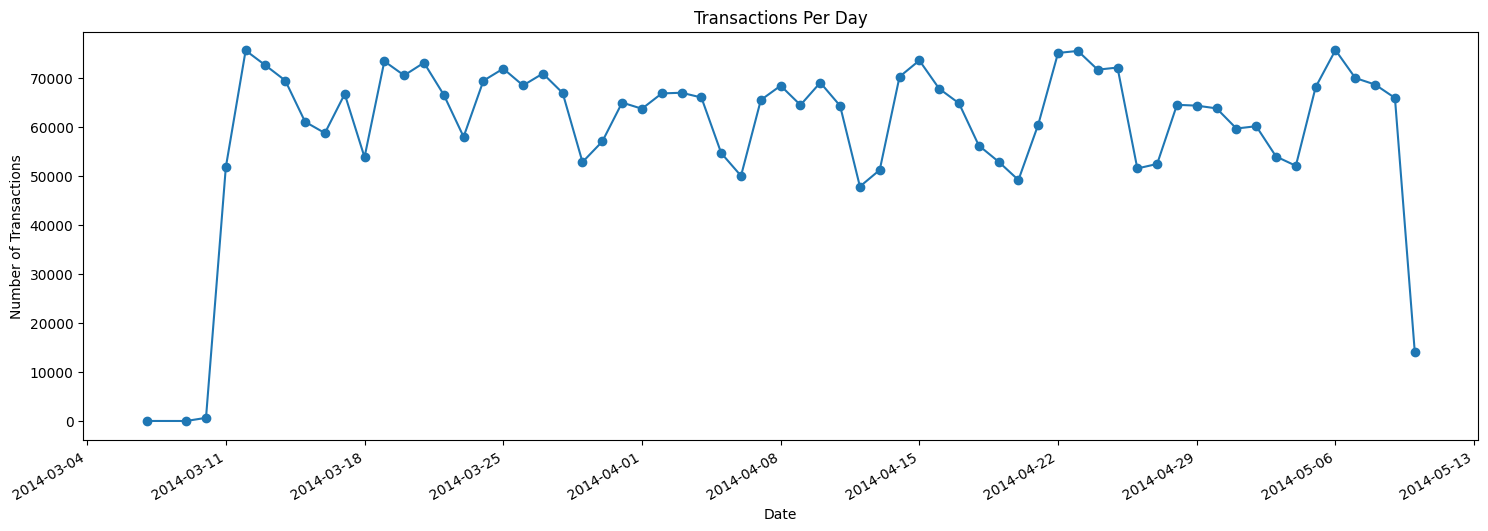

In [ ]:
import matplotlib.dates as mdates
from datetime import datetime

collected_data = spark.sql("""
    SELECT transaction_date, COUNT(*) as transactions
    FROM temp_usd_transactions
    WHERE transaction_date <= '2024-12-31 00:00:00' AND transaction_date >= '2014-03-01 00:00:00'
    GROUP BY transaction_date
    ORDER BY transaction_date ASC
""").collect()

dates = [row['transaction_date'] for row in collected_data]
transactions = [row['transactions'] for row in collected_data]

sorted_data = sorted(zip(dates, transactions), key=lambda x: x[0])
dates, transactions = zip(*sorted_data)

plt.figure(figsize=(18, 6))
plt.plot(dates, transactions, marker='o')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.title('Transactions Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')

plt.show()

### Evolution of currency transferred over time

Display a graph that shows the evolution of the amount of currency transferred (in BTC and USD) over time.


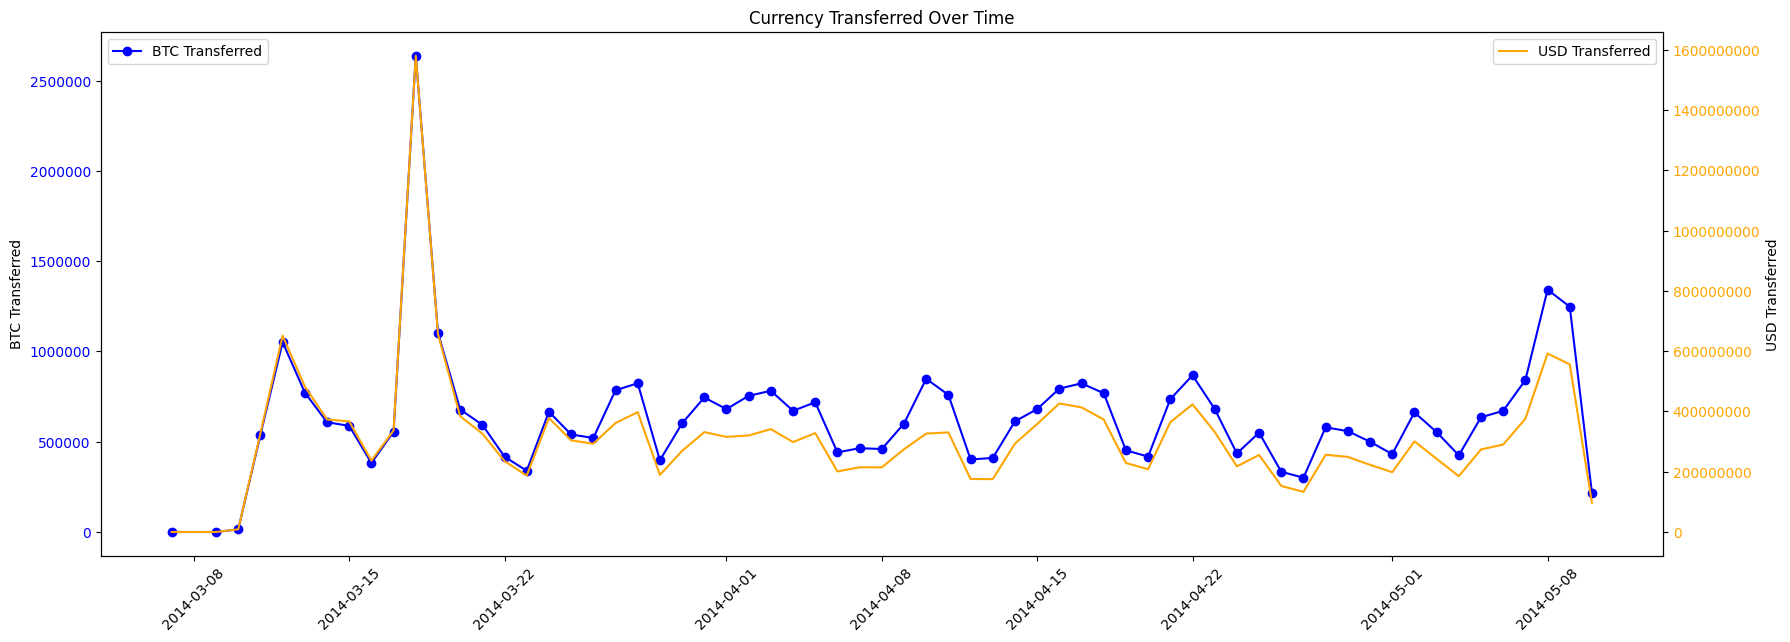

In [ ]:
from matplotlib.ticker import FuncFormatter

currency_evolution = spark.sql("""
    SELECT
        transaction_date AS date,
        SUM(sum) AS total_BTC_transferred,
        SUM(USD) AS total_USD_transferred
    FROM
        temp_usd_transactions
    WHERE transaction_date <= '2024-12-31 00:00:00' AND transaction_date >= '2014-03-01 00:00:00'
    GROUP BY
        transaction_date
    ORDER BY
        transaction_date
""")

collected_data = currency_evolution.collect()

dates = [row['date'] for row in collected_data]
btc_transferred = [row['total_BTC_transferred'] for row in collected_data]
usd_transferred = [row['total_USD_transferred'] for row in collected_data]

sorted_data = sorted(zip(dates, btc_transferred, usd_transferred), key=lambda x: x[0])
dates, btc_transferred, usd_transferred = zip(*sorted_data)

plt.figure(figsize=(18, 6))

ax1 = plt.gca()
ax1.plot(dates, btc_transferred, marker='o', color='blue', label='BTC Transferred')
ax1.set_ylabel('BTC Transferred')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())

ax2 = ax1.twinx()
ax2.plot(dates, usd_transferred, color='orange', label='USD Transferred')
ax2.set_ylabel('USD Transferred')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

formatter = FuncFormatter(lambda x, _: f'{x:.0f}')
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

plt.title('Currency Transferred Over Time')
plt.tight_layout()
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

plt.show()

For a better visualization of the graph we filtered the data with information from 2014-03-01 to 2024-12-31.

## Exercise 2 [4 points]

Assume you want to create a web site with information about bitcoin. In this website, a user could go and get some statistics for any Bitcoin address. You can select the statistics you want to maintain - you should maintain at least three statistics - suggestions: address account balance (mandatory); top-3 commercial partners; average transaction value.

To support this web site, it would be necessary to build one or more indices that would be used to answer the query of the user. In this context a index is a table that maps an address to a value of the statistics being computed.

Write the code to build these indices - for each index, print 5 lines.

**NOTE:** use the data from a single dataset file (even knowing that the value of the account balance would need to include processing all transactions).


In [ ]:
df

,TxId,Height,Input,Output,Sum,Time
0,290003:0,290003,[17WqA7z67HvhNoSaZ4X5YfuhwW2hjSRViQ],"[[16SUYiQ1AAsYnKnML71F7rFC35iRsEnUog, 130.0], ...",200.000000,2014-03-11 09:02:47
1,290003:1,290003,[1LKyrVaVbnNDtH3ZpsFXjA1GyRmSPBxow6],"[[1QA3WPedD6ecZdvXtDXnVRbbZBPgrHCJms, 4.0], [1...",234.235000,2014-03-11 09:04:15
2,290003:2,290003,[1GJaFGAkEGYEk8L6hjpQBkWxtFwEsgC8YX],"[[1EWXnhAwoX5PfaH2tkySSdgPhezAUcJipm, 62.16472...",62.363657,2014-03-11 09:06:12
3,290003:3,290003,[15xiShqUqerfjFdyfgBH1K7Gwp6cbYmsTW],"[[1ArbcawfWA44xFeAKP7QiEVkF9ptaAUAuQ, 0.109514...",25.170401,2014-03-11 09:00:06
4,290003:4,290003,[1L1F7whoW4Mmk5NMxgY2EV8Kj6eoVX52wW],"[[1GNbYn6i9TJZQhoH1jrmcvD1pq3aB823V1, 2.0], [1...",9.723483,2014-03-11 08:36:06
...,...,...,...,...,...,...
3848927,300000:231,300000,"[1GfVDSkCkzWGrL7vYi64zQtwFtuuWGScgo, 1EUwRMSF3...","[[1NdSheq5x4BLnpUySpXaRWaj7pha3WZLNk, 0.0869],...",1.663257,2014-05-10 06:30:20
3848928,300000:232,300000,"[14b32APrimF3kcFkmrm8z5i62MTUsV4M7M, 13KpxCS1R...","[[1mjD6Fa6EbxDMURLwR4ZC9T2dkByAV9oa, 0.03], [1...",2.588719,2014-05-10 06:30:41
3848929,300000:233,300000,"[1CadKYXvZ27TZKWrDZjnct2VVYfZ8xz2iy, 1KgX4J18U...","[[1E7UnBpFd5tWvFvyks3tzmffpQVjX4tB9J, 0.000297...",0.106864,2014-05-10 06:28:29
3848930,300000:234,300000,"[1HP8RR2qdDV4jc8VF195KkRzq2MwwyGUk, 12Bb4dpdEZ...","[[15F6BtjeEjWdtPAPQMietohyhjrMx8yiLV, 0.052364...",0.052755,2014-05-10 06:30:13


In [ ]:
def calculate_balances(dataset):
    balances = {}

    for index in range(len(dataset)):
        row = dataset.iloc[index]

        inputs = row['Input']
        outputs = row['Output']

        for input_address in inputs:
            if input_address not in balances:
                balances[input_address] = 0
            balances[input_address] = 0

        for output_entry in outputs:
            output_address, value = output_entry
            if output_address not in balances:
                balances[output_address] = 0
            balances[output_address] += value

    return balances


account_balances = calculate_balances(df)
account_balance_df = pd.DataFrame(list(account_balances.items()), columns=['Address', 'Balance'])
account_balance_df.sort_values('Balance', ascending=False, inplace=True)
account_balance_df



,Address,Balance
5140772,1NiQRm3aARLeiYBNYJwcAFXE4Kw3fRurbp,56193.000000
1689023,15CVfJUC1LKn1GKZx6RM5UMbFfnTd8vTT4,20000.000255
1790386,13ssxUjmQqemuiBfJSBsr7gFX7UWU7uXNK,19960.231130
1952285,1JhTY9r4fzdeiRNQesHEmq4LUw3oEP7Yzh,15159.098591
4043447,1CmerFgWzvV48SU9momQhBcuCSS8aJ3iPw,14000.000000
...,...,...
2197709,1EB2AYTiGKhAX7zkBC6A5J4LkM3jyGxjQG,0.000000
2197708,1D9rVNL8h13T3iuBnjdT4QJQgivTHGL4uv,0.000000
2197707,1J528YLZQetTUxUTJQfMFUEEgD94CpegHZ,0.000000
2197706,19v1Qr1zvyF62PcrdvG9y7mShyk2SuZvc7,0.000000


In [ ]:
#Average transaction received
average_received_df = outputDF.groupby("Output")["Value"].mean().reset_index()
average_received_df = average_received_df.rename(columns={"Value":"Average Received","Output":"Address"}).sort_values("Average Received",ascending=False)
average_received_df

,Address,Average Received
742396,153axhS1Xs3evJ5gWD1x2QU48u9ASvS3r4,8.299300e+04
3193415,1FFiXAwoeLDvzPmcifNTDiGhdJM8GkvZAg,7.869300e+04
4017692,1JgXeXaAvBgdKN9om8h92yqwgPzzSAD438,7.069300e+04
3223985,1FP7sqERBQLqDSE9MNzTUbUx5Xz8vQjW2y,6.869300e+04
4611722,1M9xLRZkmJ8PAYzp4zTu7P6SarKHt3pm9X,6.319300e+04
...,...,...
4072646,1JumXcGKcPvF6JsaJNdQhTbzrYwByVjwhU,1.000000e-08
2654464,1D1hC6R1gyPF3pj4k73mck515BQjeaACJ1,1.000000e-08
943121,15tt78ntyaEMnHsYBBiDHexTnjKLph3oFT,1.000000e-08
3992394,1JaQp6QRB7pnBJkbYR8yBsnUwyz6prEUen,1.000000e-08


In [ ]:
#Number of transfers received
transfer_counts_df = outputDF.groupby("Output")["Value"].count().reset_index()
transfer_counts_df = transfer_counts_df.rename(columns={"Value":"Transfers Received","Output":"Address"}).sort_values("Transfers Received",ascending=False)
transfer_counts_df

,Address,Transfers Received
5428033,1changemCPo732F6oYUyhbyGtFcNVjprq,60873
5045902,1NxaBCFQwejSZbQfWcYNwgqML5wWoE3rK4,51194
5424417,1bonesF1NYidcd5veLqy1RZgF4mpYJWXZ,41838
4552492,1LuckyR1fFHEsXYyx5QK4UFzv3PEAepPMK,18086
5424413,1bones8VWK2LbDYZ8TJAME9gpHaV2ZCGT,17267
...,...,...
1968217,1AAH7ofQiGt9rAgANTyTWs7dFZKTzhTsEJ,1
1968216,1AAH7gHVDSTjajV7i2M5Vz6jqTQd79ecTa,1
1968215,1AAH7VUYMhgkgmkURZQGR54YvEKrgaqDiV,1
1968214,1AAH77CDqJkSB1oCzihJ7qHEwGygoGtjLs,1


In [ ]:
#Number of transfers received per day

from dateutil.relativedelta import relativedelta
from datetime import datetime
date1 = datetime.strptime('2009-01-15', '%Y-%m-%d')
date2 = datetime.strptime('2010-07-17', '%Y-%m-%d')
days_difference = (date2 - date1).days

transfer_counts_df["Transfers Received Per Day"] = transfer_counts_df["Transfers Received"]/days_difference
transfer_counts_df

,Address,Transfers Received,Transfers Received Per Day
5428033,1changemCPo732F6oYUyhbyGtFcNVjprq,60873,111.082117
5045902,1NxaBCFQwejSZbQfWcYNwgqML5wWoE3rK4,51194,93.419708
5424417,1bonesF1NYidcd5veLqy1RZgF4mpYJWXZ,41838,76.346715
4552492,1LuckyR1fFHEsXYyx5QK4UFzv3PEAepPMK,18086,33.003650
5424413,1bones8VWK2LbDYZ8TJAME9gpHaV2ZCGT,17267,31.509124
...,...,...,...
1968217,1AAH7ofQiGt9rAgANTyTWs7dFZKTzhTsEJ,1,0.001825
1968216,1AAH7gHVDSTjajV7i2M5Vz6jqTQd79ecTa,1,0.001825
1968215,1AAH7VUYMhgkgmkURZQGR54YvEKrgaqDiV,1,0.001825
1968214,1AAH77CDqJkSB1oCzihJ7qHEwGygoGtjLs,1,0.001825


In [ ]:
#Maximum transfer received per account
max_received_df = outputDF.groupby("Output")["Value"].max().reset_index()
max_received_df = max_received_df.rename(columns={"Value":"Maximum Received","Output":"Address"}).sort_values("Maximum Received",ascending=False)
print(max_received_df)

#Minimum transfer received per account
min_received_df = outputDF.groupby("Output")["Value"].min().reset_index()
min_received_df = min_received_df.rename(columns={"Value":"Minimum Received","Output":"Address"}).sort_values("Minimum Received",ascending=False)
print(min_received_df)

#Median transfer received per account
median_received_df = outputDF.groupby("Output")["Value"].median().reset_index()
median_received_df = median_received_df.rename(columns={"Value":"Median Received","Output":"Address"}).sort_values("Median Received",ascending=False)
print(median_received_df)

                                    Address  Maximum Received
742396   153axhS1Xs3evJ5gWD1x2QU48u9ASvS3r4      8.299300e+04
3193415  1FFiXAwoeLDvzPmcifNTDiGhdJM8GkvZAg      7.869300e+04
4017692  1JgXeXaAvBgdKN9om8h92yqwgPzzSAD438      7.069300e+04
3223985  1FP7sqERBQLqDSE9MNzTUbUx5Xz8vQjW2y      6.869300e+04
573970   14LBeJ5bZQK1od2jixNVe2Mch1YX7WLM65      6.469300e+04
...                                     ...               ...
5051356  1NyuJ7p8KRxhmvQYPQE5FSMHxgSLiSS4Bj      1.000000e-08
1431733  17vrY3Psvi4YUg5PhFRjuZfy7KJbvZyGtJ      1.000000e-08
2357831  1BnHzSp6931GeEchhBccbGSXjKCXebUrE9      1.000000e-08
1566178  18VDD7JTkTTYdruDNFh14T3stNtDavrq9h      1.000000e-08
3805341  1HoEMfkMKHT3d74yGiCgppsoR4XCZz5JVJ      1.000000e-08

[5524556 rows x 2 columns]
                                    Address  Minimum Received
742396   153axhS1Xs3evJ5gWD1x2QU48u9ASvS3r4      8.299300e+04
3193415  1FFiXAwoeLDvzPmcifNTDiGhdJM8GkvZAg      7.869300e+04
4017692  1JgXeXaAvBgdKN9om8h92yqwgPzzSAD43

#### Discussion
To calculate the balance of each account in the dataset used, we created a function with an empty dictionary. The code is going to run in every line of the dataset ( row = dataset.iloc[index]) and check both input and output columns. For the inout column, it is going to see if the input address is already on out dictionary. If it is not, it will introduce it and make it zero. If it is already there, it will upload it to 0 as accounts that appear on the input transfered all their money. Then, after seeing the first line on the input column, it goes to the first like of the output column. For each line on the output, we gave the name output_address for tha account address and value for the amount it received. If the account is already in the dictionarry, it will update its value by summing the value received. Lastly, we converted the dictionary to a dataframe so it is easier to see and use. As we can see there are accounts with high balance, which means they received a lot of money recently or did not transfer any money. On the other hand, there accounts that transfered all the balance they had recently and now they have null balance.

In the second code we calculate the average transaction value received for each address by grouping the outputs address and computing the mean, then we rename the columns for clarity. At the end we sort the addresses in descending order based on the average value received. As we can see from the results there are accounts addresses that received a high value of transfers but there also some accounts that received very little on average.

To calculate the amount of transfers each account has received, we grouped the outpudDF dataframe by teh column "Output" and counted how many times each account appeared there with ["Value"].count(). Then, we renamed the columns so it is coherent and printed the dataframe. As we can see, there are accounts how have incurred in a lot of transactions but also some accounts that only received bitcoin transfers once. Moreover, we also computed the amount of transfers each account has received per day.

Lastly, we calculated maximum, minimum and median of total value received by each account. We grouped the addressess and applied the respective functions.

## Exercise 3 [4 points]

Explore the creation of classification models for assigning labels to addresses. Use the labels assigned in the provided dataset for training and testing.

**SUGGESTION:** use statistics associated with each address, including number of transactions, avergae amount of transactions, average number of partners per day (or other time unit), etc.

**NOTE:** building the best classification model is a never ending task, and we do not expect you to build a perfect classifier. What we expect you in this task is that you propose a set of variables and explain the relevance of such variable for helping differentiate between different classes, and that do the step to build and evaluate the classifier.


## Feature Engineering

In [ ]:
#Creation of a dataset with all the features
features1 = account_balance_df.merge(average_received_df, left_on="Address", right_on="Address", how="left")
features1 = features1.merge(transfer_counts_df, left_on="Address", right_on="Address", how="left")
features1 = features1.merge(max_received_df, left_on="Address", right_on="Address", how="left")
features1 = features1.merge(min_received_df, left_on="Address", right_on="Address", how="left")
features1 = features1.merge(median_received_df, left_on="Address", right_on="Address", how="left")
features1 = features1.dropna() #we dropped because these accoutns did not received anything

In [ ]:
features1

,Address,Balance,Average Received,Transfers Received,Transfers Received Per Day,Maximum Received,Minimum Received,Median Received
0,1NiQRm3aARLeiYBNYJwcAFXE4Kw3fRurbp,56193.000000,56193.000000,1.0,0.001825,56193.000000,56193.000000,56193.000000
1,15CVfJUC1LKn1GKZx6RM5UMbFfnTd8vTT4,20000.000255,4000.000051,5.0,0.009124,9999.999900,0.000055,0.000400
2,13ssxUjmQqemuiBfJSBsr7gFX7UWU7uXNK,19960.231130,11626.544818,3.0,0.005474,19960.231130,0.000055,14919.403269
3,1JhTY9r4fzdeiRNQesHEmq4LUw3oEP7Yzh,15159.098591,15159.098591,1.0,0.001825,15159.098591,15159.098591,15159.098591
4,1CmerFgWzvV48SU9momQhBcuCSS8aJ3iPw,14000.000000,14000.000000,1.0,0.001825,14000.000000,14000.000000,14000.000000
...,...,...,...,...,...,...,...,...
5748609,1EB2AYTiGKhAX7zkBC6A5J4LkM3jyGxjQG,0.000000,0.554208,1.0,0.001825,0.554208,0.554208,0.554208
5748610,1D9rVNL8h13T3iuBnjdT4QJQgivTHGL4uv,0.000000,0.602116,1.0,0.001825,0.602116,0.602116,0.602116
5748611,1J528YLZQetTUxUTJQfMFUEEgD94CpegHZ,0.000000,0.645566,1.0,0.001825,0.645566,0.645566,0.645566
5748612,19v1Qr1zvyF62PcrdvG9y7mShyk2SuZvc7,0.000000,0.610371,1.0,0.001825,0.610371,0.610371,0.610371


In [ ]:
#Combining the features1 and the labels dataset
dataFileName = os.path.join(DATASET_DIR1, LABEL)

features_labeled = pd.read_csv(dataFileName, compression = "gzip")
features_labeled['address'] = features_labeled['address'].str.replace("'", "")

features_labeled = features1.merge(features_labeled, left_on="Address", right_on="address", how="inner")
features_labeled = features_labeled.drop(columns=["name","date_first_tx","country","address"])
features_labeled

,Address,Balance,Average Received,Transfers Received,Transfers Received Per Day,Maximum Received,Minimum Received,Median Received,type
0,1HUFu77ps9YLaUYFN5UDs3nM49RECF6WYt,1708.076800,28.001259,61.0,0.111314,440.000000,2.142400,21.876400,mining
1,1FKFSu3f3jNwjwSkmpLSGrsd1FPXr3Wdbb,555.765978,58.405025,159.0,0.290146,999.000000,0.005352,19.999900,exchanges
2,18XYPiF58UXizUGwPynfG8G4dAmAXp9B6L,401.487162,174.536537,6.0,0.010949,401.487162,9.363435,141.802735,service
3,1Q8om5y42HM8pxxSND1BrzuWDhixDVyy8o,370.497000,370.497000,1.0,0.001825,370.497000,370.497000,370.497000,service
4,1E581oUnR5eJ9oPHtut1N5CcyYWHK4Ct7H,344.353400,120.996263,16.0,0.029197,379.799900,0.065300,5.082350,service
...,...,...,...,...,...,...,...,...,...
1016242,1KQs4PMKK7EmRLgRjXqssgJcC23CKB3NLu,0.000000,1.764000,1.0,0.001825,1.764000,1.764000,1.764000,service
1016243,12ZioDqNdwuLvfofar86DN1wyZiKvJB6mx,0.000000,1.750000,1.0,0.001825,1.750000,1.750000,1.750000,service
1016244,16S99EXQKX7Ry6v3z6CHDhkNPzuC3Wo1oC,0.000000,0.491333,3.0,0.005474,1.219000,0.065000,0.190000,historic
1016245,1KQmFEdZ9LrDW6yoMtwE6yZspZWeE67w1i,0.000000,1.300000,1.0,0.001825,1.300000,1.300000,1.300000,service


## Creating the Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score

x = features_labeled.drop(columns=["type", "Address"])
y = features_labeled["type"]

#KNN CLASSIFIER
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
knn = KNeighborsClassifier(n_neighbors=21, weights='distance')
knn.fit(x_train, y_train)

# Accuracy
print(f"The test set's accuracy is {knn.score(x_test, y_test)}")
print(f"The training set's accuracy is {knn.score(x_train, y_train)}")

The test set's accuracy is 0.7093431734317344
The training set's accuracy is 0.9232065268493432


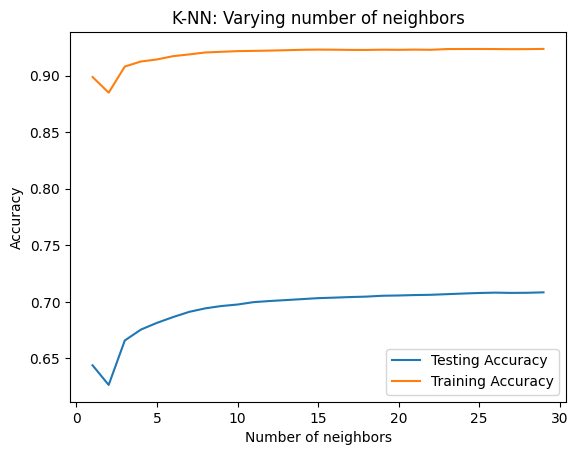

In [ ]:
#To create the best model, we evaluated the model with different nº of k neighbors

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

neighbors = np.arange(1,30)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors = k, weights='distance')
    knn.fit(x_train,y_train)

    train_accuracy[i] = knn.score(x_train,y_train)
    test_accuracy[i] = knn.score(x_test,y_test)

plt.title("K-NN: Varying number of neighbors")
plt.plot(neighbors, test_accuracy, label = "Testing Accuracy")
plt.plot(neighbors, train_accuracy, label = "Training Accuracy")
plt.legend()
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.show()

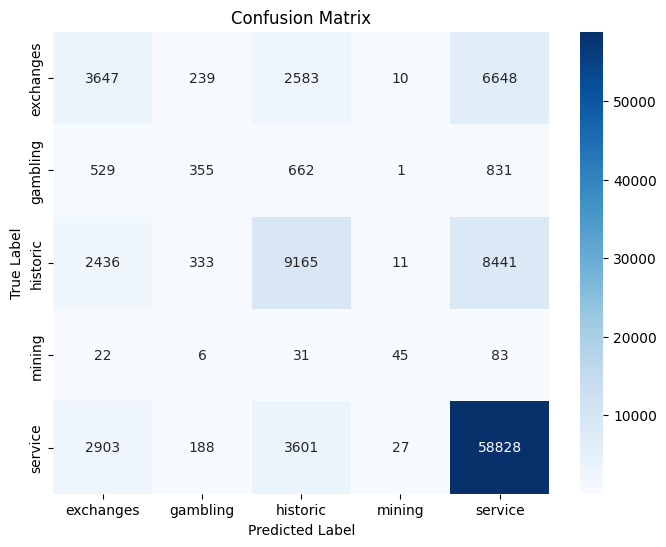

              precision    recall  f1-score   support

   exchanges       0.38      0.28      0.32     13127
    gambling       0.32      0.15      0.20      2378
    historic       0.57      0.45      0.50     20386
      mining       0.48      0.24      0.32       187
     service       0.79      0.90      0.84     65547

    accuracy                           0.71    101625
   macro avg       0.51      0.40      0.44    101625
weighted avg       0.68      0.71      0.69    101625

Precision: 0.6793470103319356
Recall: 0.708880688806888
Accuracy: 0.708880688806888


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
knn = KNeighborsClassifier(n_neighbors=21, weights='distance')
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

# Confusion Matrix code
conf_matrix = confusion_matrix(y_test, y_pred)

# To better understand the confusion matrix, we plotted it using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report, precission, recall and accuracy
print(classification_report(y_test, y_pred))


print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_pred))

#### **Discussion**

To create a classification model, we merged all the statistics calculated into "features 1". Then, we open the dataset referent to the labels and proseded to cleaning the data necessary to match the format we wanted, and merged "features1" with this dataset on the "address" column. This way, we have the type for each account.

After, we trained the model with 10% of our data and created our KNN classifier with 21 neighbors, meaning that when making a prediction for a new data point, the classifier will consider the labels of the 21 nearest neighbors. Then, we gave weights to our data so that the contributions of neighbors are weighted when making predictions, to increase the accuracy of the model. In this case, we decided to use "distance" meaning that the closer neighbors will have a stronger influence on the prediction than farther neighbors. As the weight is  inversely proportional to the distance, closer neighbors will have a greater impact. With this, we got a test set accuracy of 71% and a training set accuracy of 92%.

Lastly, we evaluated the model with different number of neighbors and evaluated its training and test accuracy. After plotting the graph of this evolution, we can see that until 2 neighbours the accuracy tends to decrease, but after that it will increase. From 5 to 10 neighbors it will increase at a decreasing rate and from 10 onwards it will increase at such a small rate that it is almost constant.

So, in general, the higher the number of neighbors, the better the accuracy of the model. It may result in a smoother decision boundary and a more stable model, will providing more robustness to noisy data and reduce the risk of overfitting. However,  it might oversmooth the decision boundary and lead to underfitting.


Lastly, we created a confusion matrix that displays the classification results for our model that has five categories: exchanges, gambling, historic, mining, and service. The diagonal elements of our matrix represent the correct classifications, while off-diagonal elements indicate misclassifications. For instance, 'service' has a high number of true positives (58828), indicating a strong model performance for this category. However, categories like 'gambling' and 'mining' show lower true positives, meaning that the model had difficulties in accurately classifying these types.
In general, the matrix suggests that the model is particularly effective at identifying 'service' but less so for other categories, potentially requiring further model tuning or additional features to improve classification accuracy across all categories.
The precision of 0.679 suggests that when the model predicts a class label, it is correct about 67.9% of the time across all classes. The recall of 0.709 means that the model successfully identifies 70.9% of all relevant instances across the dataset. Lastly, the accuracy of 70.9% shows that the model correctly predicts the class label for a given input 70.9% of the time. These metrics suggest a reasonably good classifier but also highlight room for improvement, particularly in precision and recall for certain classes, as seen in the confusion matrix.

## Exercise 4 [4 points]

Consider we didn't have the labels for the address, but that you would want to create groups of addresses. Propose a solution.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

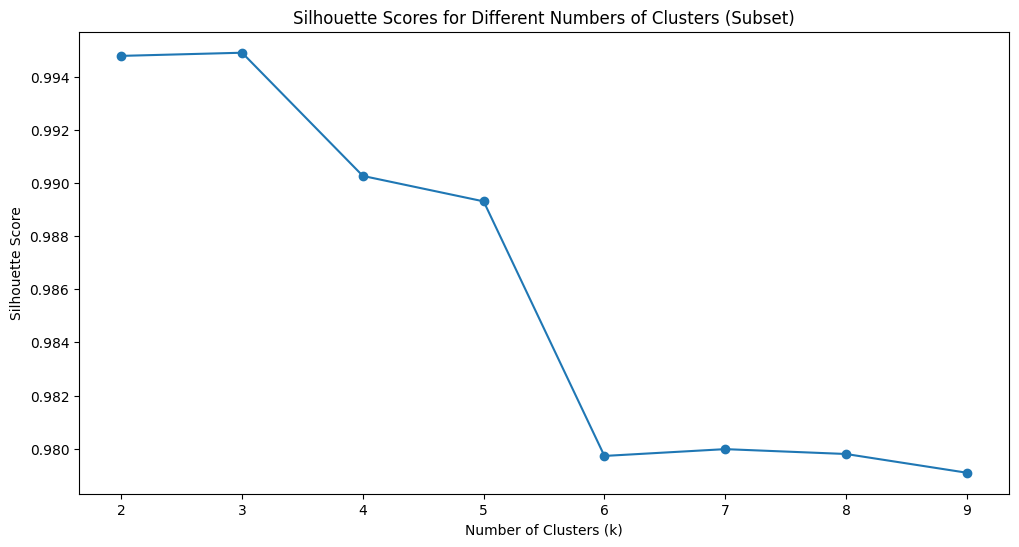

Optimal k for subsample: 3


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# To perform this analysis more efficiently, we created a subset of our data
features1_subset = features1.sample(n=250000, random_state=420).drop(columns=["Address"])


scaler = StandardScaler()
X_subset_scaled = scaler.fit_transform(features1_subset)

# Function that evaluates different values of clusters
def evaluate_clusters(data, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data)
    score = silhouette_score(data, labels)
    return score

# Evaluation of the performance of range values of clusters (between 2 and 10)
scores = [(k, evaluate_clusters(X_subset_scaled, k)) for k in range(2, 10)]


scores_df = pd.DataFrame(scores, columns=['k', 'score'])
optimal_k = scores_df.loc[scores_df['score'].idxmax(), 'k']

# Plotting the silhouette scores for the subset
plt.figure(figsize=(12,6))
plt.plot(scores_df['k'], scores_df['score'], marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters (Subset)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

print("Optimal k for subsample: {}".format(optimal_k))


In [ ]:
kmeans = KMeans(n_clusters = optimal_k, n_init='auto', random_state=1)
kmeans.fit(X_subset_scaled)
labels = kmeans.predict(X_subset_scaled)

In [ ]:
pd.DataFrame(labels).rename(columns={0:'Clusters'}).value_counts('Clusters')

Clusters
0    249835
1       155
2        10
dtype: int64

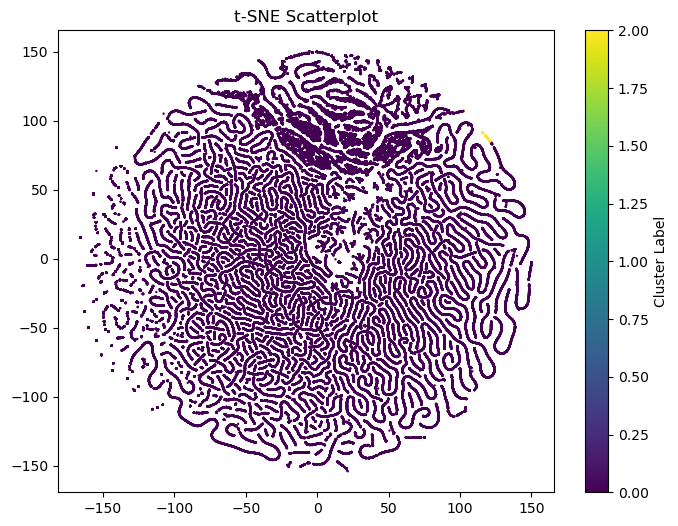

In [ ]:
from sklearn.manifold import TSNE

# Use TSNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=1)
tsne_result = tsne.fit_transform(X_subset_scaled)

# Plot the TSNE scatterplot for and easier understanding
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis', s=0.5)
plt.colorbar(scatter, label='Cluster Label')
plt.title(f't-SNE Scatterplot')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


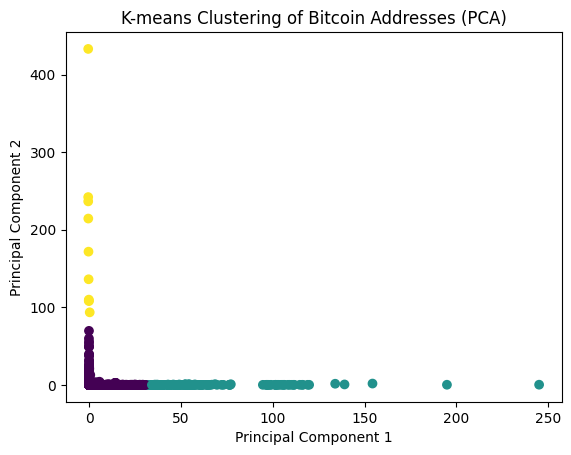

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# To perform this analysis more efficiently, we created a subset of our data
features1_subset = features1.sample(n=250000, random_state=420).drop(columns=["Address"])


scaler = StandardScaler()
features_scaled = scaler.fit_transform(features1_subset)

# Use TSNE to reduce dimensionality
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)


kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(features_pca)
features1_subset['cluster'] = cluster_labels

# Plot the clusters with PCA dimensionality reduction
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('K-means Clustering of Bitcoin Addresses (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


#### **Discussion**
To group the data, we should do clustering.

Our approach used clustering to identify possible groupings of Bitcoin addresses. The silhouette scores technique helped us to understand what was the best number of clusters to consider in our dataset. With it, we concluded that the the optimal number of clusters would be 3 as it is the one that gives us the highest silhouete score of 0,995.

With this information, we used the KMeans algorithm to divide the data into the 3 clusters and fitted in to our data. After bulding the model and training it with our data, we counted the number of points in each cluster that helped us to understand that there was a higher concentration of points in the first cluster. To better understand this phenomenon, we decided to plot the data.

To plot the data, we procedeed with dimensionality reduction using both techniques: TSNE and PCA.
As we learned, TSNE is a non-linear dimensionality reduction technoque while PCA is linear.

By the TSNE, that is commonly used to better visualize high-dimensional data in 2 dimensions, we can really see the strongest presence of the first clustr (printed in purple), a little of the other cluster (printed in yellow) and very little of the third and last cluster.

By the PCA, that is effective at preserving the global structure of the data and reducing the noise and feature engineering of the data by focusing on the most important features, the graph is much cleaner. First, it is easier to observe the three clusters (printed in yellow, purple and blue). Moreover, it is also easier to identify their similarities, although both the x and y-axis do not ahve any meaning:
- yellow cluster: null values for the x-axis and big values for the y-axis
- purple cluster: null and small values for both the x-axis and the y-axis
- blue cluster: null values for the y-axis and big values for the x-axis

This provides a visual and intuitive understanding of the separation and concentration of the 3 clusters created, which helps to confirm the efficiency of the KMeans clustering computed above.

## Exercise 5 [3+1 points]

Propose a problem to solve and implement it (for 3 points).

Use cuDF/cuML/cuGrpahs for 1 extra point.

In [7]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules
WITH_SPARK = IN_COLAB

if IN_COLAB:
    !apt-get install openjdk-11-jdk-headless
    !pip install pyspark
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.2-spark3.2-s_2.12.jar pyspark-shell'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk-headless is already the newest version (11.0.21+9-0ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
--2023-12-04 23:16:13--  https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar
Resolving repos.spark-packages.org (repos.spark-packages.org)... 13.224.14.11, 13.224.14.81, 13.224.14.17, ...
Connecting to repos.spark-packages.org (repos.spark-packages.org)|13.224.14.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247880 (242K) [binary/octet-stream]
Saving to: ‘graphframes-0.8.2-spark3.2-s_2.12.jar’

graphframes-0.8.2-s 100%[===================>] 242.07K  --.-KB/s    in 0.02s   

2023-12-04 23:16:13 (10.6 MB/s) - ‘graphframes-0.8.2-spark3.2-s_2.12.jar’ saved [247880/247880]



In [8]:
!nvidia-smi
!nvcc -V

Mon Dec  4 23:16:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!pip uninstall --yes protobuf tensorflow tensorboard; pip install cupy-cuda11x

!pip install cudf-cu11 dask-cudf-cu11 cuml-cu11 cugraph-cu11 --extra-index-url https://pypi.nvidia.com

Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3
Found existing installation: tensorflow 2.14.0
Uninstalling tensorflow-2.14.0:
  Successfully uninstalled tensorflow-2.14.0
Found existing installation: tensorboard 2.14.1
Uninstalling tensorboard-2.14.1:
  Successfully uninstalled tensorboard-2.14.1
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 902.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB ? eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 5.1 MB/s eta 0:00:00
     ━━━

In [3]:
# Bitcoin price
BTCPRICE_FILE = "btc_price.csv"

In [1]:
import cudf
import cuml
import cuml.linear_model
import cuml.metrics
import cupy as cp
import matplotlib.pyplot as plt
from cuml.model_selection import train_test_split
from cuml.linear_model import LinearRegression
from cuml.metrics.regression import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [23]:
# Interest Rate file
file_path = os.path.join("/content/drive/MyDrive/", "interest_rates.csv")
interest_rates_df = cudf.read_csv(file_path)
interest_rates_df

# Bitcoin price file
date_cols = ["Date"]
path = os.path.join(DATASET_DIR, BTCPRICE_FILE)
priceDF = cudf.read_csv( path,parse_dates=date_cols)
priceDF

,Date,Price
0,2009-01-15,0.1
1,2009-01-16,0.1
2,2009-01-17,0.1
3,2009-01-18,0.1
4,2009-01-19,0.1
...,...,...
5417,2023-11-15,37874.9
5418,2023-11-16,36161.2
5419,2023-11-17,36595.4
5420,2023-11-18,36568.6


In [62]:
 # Merging the two datasets
interest_rates_df['DATE'] = cudf.to_datetime(interest_rates_df['DATE'])
merged_data = priceDF.merge(interest_rates_df, left_on='Date', right_on = "DATE").drop(columns=["DATE"]).rename(columns={"DFF": "US_Interest_rate"}).sort_values("Date", ascending=True)
merged_data = merged_data[merged_data["Date"]>="2021-01-01"]
merged_data

,Date,Price,US_Interest_rate
1793,2021-01-01,29359.9,0.09
1794,2021-01-02,32193.3,0.09
1795,2021-01-03,32958.9,0.09
1796,2021-01-04,32022.6,0.09
1797,2021-01-05,33991.5,0.09
...,...,...,...
5185,2023-11-05,35019.4,5.33
4624,2023-11-06,35042.0,5.33
4625,2023-11-07,35426.1,5.33
4626,2023-11-08,35636.9,5.33


In [63]:
# Pearson correlation coefficient
correlation = merged_data['Price'].corr(merged_data['US_Interest_rate'])
print("Correlation between Price and US Interest Rate:", correlation)

Correlation between Price and US Interest Rate: -0.6861575252150713


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:190: UserWarning: Changing solver from 'eig' to 'svd' as eig solver does not support training data with 1 column currently.
  return func(*args, **kwargs)


Mean Squared Error: 75986666.23212136
Mean Absolute Error: 7305.804716805727
R-squared: 0.46699194469674443


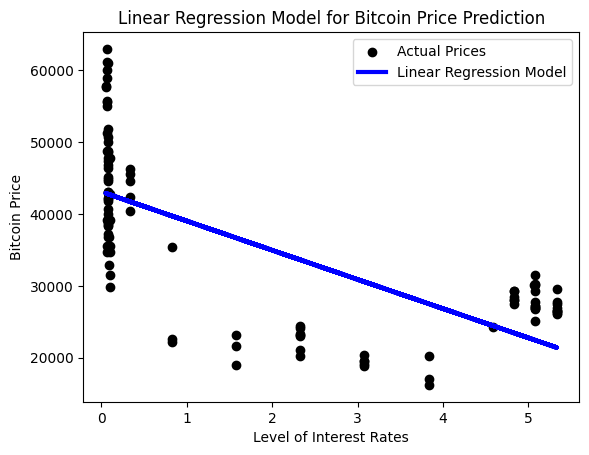

In [64]:
X_cudf = cudf.DataFrame({'US_Interest_rate': merged_data['US_Interest_rate'].astype('float64')})
y_cudf = merged_data['Price'].astype('float64')


X_train_cudf, X_test_cudf, y_train_cudf, y_test_cudf = cuml.train_test_split(X_cudf, y_cudf, test_size=0.1, random_state=42)
model = LinearRegression()
model.fit(X_train_cudf, y_train_cudf)
y_pred_cudf = model.predict(X_test_cudf)

# Model Evaluation
mse_cudf = mean_squared_error(y_test_cudf, y_pred_cudf)
mae_cudf = mean_absolute_error(y_test_cudf, y_pred_cudf)
r2_cudf = r2_score(y_test_cudf, y_pred_cudf)

print(f'Mean Squared Error: {mse_cudf}')
print(f'Mean Absolute Error: {mae_cudf}')
print(f'R-squared: {r2_cudf}')

# Plot the results using matplotlib
X_test_np = cp.asnumpy(X_test_cudf['US_Interest_rate'].to_numpy())
y_test_np = cp.asnumpy(y_test_cudf.to_numpy())
y_pred_np = cp.asnumpy(y_pred_cudf.to_numpy())

plt.scatter(X_test_np, y_test_np, color='black', label='Actual Prices')
plt.plot(X_test_np, y_pred_np, color='blue', linewidth=3, label='Linear Regression Model')
plt.xlabel('Level of Interest Rates')
plt.ylabel('Bitcoin Price')
plt.title('Linear Regression Model for Bitcoin Price Prediction')
plt.legend()
plt.show()

#### Discussion

QUESTION: Are bitcoin prices and daily USA interest rate correlated? Can we predict bitcoin prices based on the changes on interest rate?

**Explain your code and discuss results**
For this exercise, we used the GPU-accelerated to open the necessary files for out analysis:
- bitcoin prices per day
- Interest rate per day in the USA

Then, we converted the "DATE" column of the interest rate dataframe to make sure we could merge it with the bitcoin prices dataframe. After merging and applying the necessary transformations to it, we filtered the data to only have values from 2021-01-01 onwards. This way, we could easily answer our question!

To answer the first part of our exercise, we calculated the pearson correaltion coefficient to learn more about the relationship between bitcoin prices and daily interest rates in the USA. We got a value of -69% that shows that, on average, when one of the variables increase, the other tends to decrease.


To create the model, we split the dat into training and testing sets. Then, we created the linear regression model with cuML. Lastly, we trained the model with our traing data and made predictions with the test sets. Finally, to evaluate our model, we computed the Mean Squared Error (mse_cudf), Mean Absolute Error (mae_cudf), and R-squared (r2_cudf) using cuML's metrics functions, and ploted the model for an easier visualization.


Furthermore, we explored the potential impact of US interest rates on Bitcoin investment trends. Given the low-interest-rate environment, the hypothesis was that investors might diversify into alternative assets like Bitcoin, possibly affecting its transaction volumes and prices. As we can see by the graph plotted and by the correlation between these 2 variables, if interest rates increase, traditional investments such as bonds may become more appealing, leading investors to move away from riskier assets like cryptocurrencies. This means that, when interest rates rise, the cost of capital increases, and investors may become more risk-averse, moving away from riskier assets and towards safer investments. This realtionshop makes sense because, if interest rates rise due to concerns about inflation, investors might seek refuge in assets that are considered more stable (not cryptocurrencies because they are not regulated), potentially leading to a decrease in demand for cryptocurrencies.


The model that we created has an R-squared of 46.7%, indicating a substantial but incomplete explanation of Bitcoin's price variability by interest rates alone.
The data exhibited significant dispersion around the trend line, suggesting that other additional factors affect the prices of bitcoin.
For enhanced model accuracy, incorporating broader economic metrics such as inflation rates, stock market performance, and crypto-market dynamics could yield a more comprehensive understanding of Bitcoin's price determinants.